# Notebook for Semantics Analysis Training to Map Sentences to Suggested ESCU Contents

# Stage 0 - download models and import libraries

In [2]:
!pip install sentence_transformers

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 138.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 131.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.7/450.7 kB 60.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.16.2
    Uninstalling transformers-4.16.2:
      Successfully uninstalled transformers-4.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
simplet5 0.1.4 requires transformers==4.16.2, but you have transformers 4.48.1 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.metrics import DistanceMetric

import matplotlib.pyplot as plt
import matplotlib as mpl

# load data

In [45]:
df = pd.read_csv("/srv/notebooks/data/E5CU_DataSource.csv", encoding='latin-1', usecols=['id_desc', 'datasource'])

In [46]:
df.head()

,id_desc,datasource
0,3cx_supply_chain_attack_network_indicators:The...,DNS
1,7zip_commandline_to_smb_share_path:This search...,Endpoint Detection and Response
2,abnormally_high_aws_instances_launched_by_user...,AWS
3,abnormally_high_aws_instances_terminated_by_us...,AWS
4,abnormally_high_number_of_cloud_infrastructure...,Change Events Data


# generate embeddings

In [60]:
# import pre-trained model (full list: https://www.sbert.net/docs/pretrained_models.html)
model = SentenceTransformer("all-MiniLM-L6-V2")

MODEL_DIRECTORY = "/srv/app/model/data/"

model = SentenceTransformer('all-MiniLM-L6-V2')
model = SentenceTransformer(MODEL_DIRECTORY)

#embed vectors
embedding_arr = model.encode(df['id_desc'])
embedding_arr.shape

model.save(MODEL_DIRECTORY)

# Visualize Embeddings

# PCA

In [53]:
#apply PCA to embeddings
pca = PCA(n_components=2).fit(embedding_arr)
print(pca.explained_variance_ratio_)

[0.0759178  0.04607461]


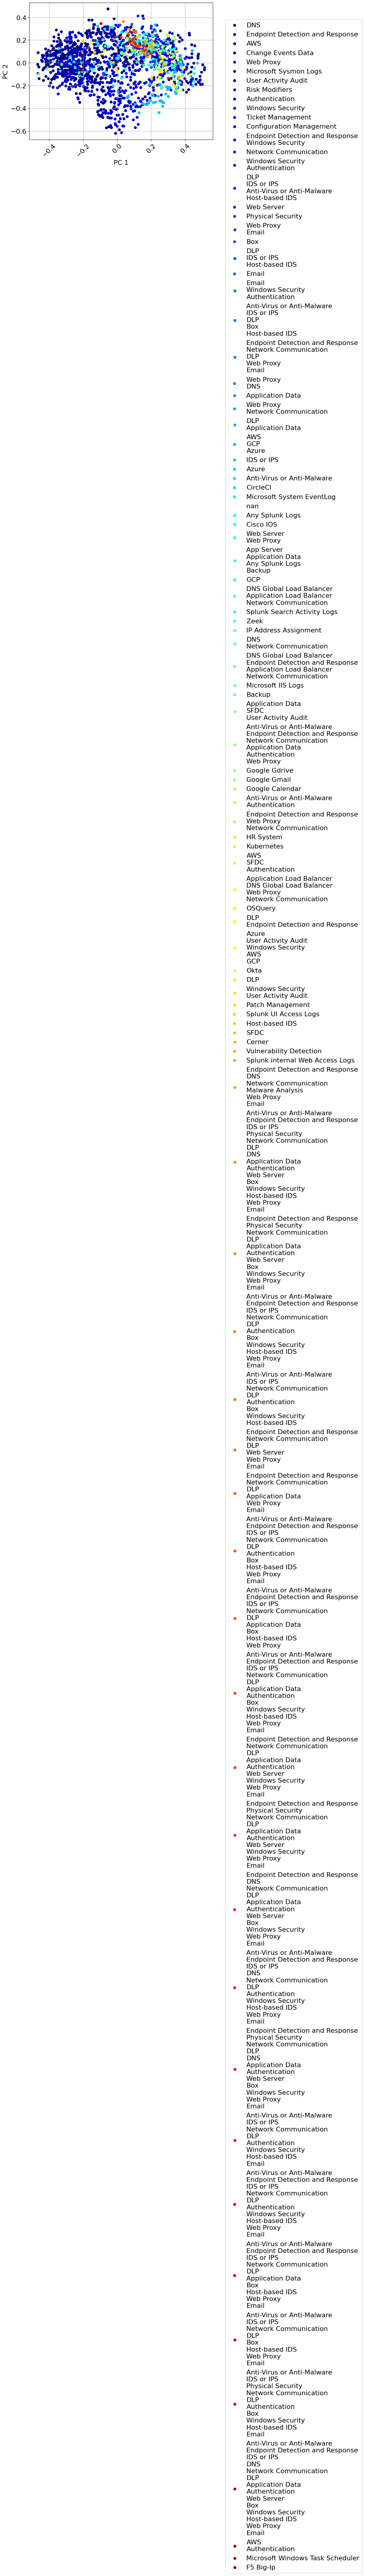

In [54]:
# plot data along PCA components
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.grid()

c=0
cmap = mpl.colormaps['jet']
for datasource in df['datasource'].unique():
    idx = np.where(df['datasource']==datasource)
    plt.scatter(pca.transform(embedding_arr)[idx,0], pca.transform(embedding_arr)[idx,1], c=[cmap(c)]*len(idx[0]), label=datasource)
    c = c + 1/len(df['datasource'].unique())

plt.legend(bbox_to_anchor=(1.05, 0.9))
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

# Semantic Search

In [55]:
query = "In the case of malspam, we have observed consistent use of invoice-related and job agency themes that entice victims to access hyperlinks present in either the email body, or within attached documents, such as PDFs."

In [56]:
# embed query
query_embedding = model.encode(query)

In [57]:
# define distance metric
dist = DistanceMetric.get_metric('euclidean') # other distances: manhattan, chebyshev

# compute pair wise distances between query embedding and all resume embeddings
dist_arr = dist.pairwise(embedding_arr, query_embedding.reshape(1, -1)).flatten()
# sort results
idist_arr_sorted = np.argsort(dist_arr)

In [58]:
# print datasource of top 10 closest datasource to query in embedding space
print(df['datasource'].iloc[idist_arr_sorted[:10]])

1422    Endpoint Detection and Response
544                        Google Gmail
439                               Email
1020                              Email
543                        Google Gmail
1502              Microsoft Sysmon Logs
548                       Google Gdrive
1102                              Email
1534    Endpoint Detection and Response
481                 User Activity Audit
Name: datasource, dtype: object


In [59]:
# print id_desc closest to query in embedding space
print(df['id_desc'].iloc[idist_arr_sorted[0]])
print(df['id_desc'].iloc[idist_arr_sorted[1]])
#print(df['id_desc'].iloc[np.r_[1]])

windows_phishing_pdf_file_executes_url_link:This analytic is developed to detect suspicious pdf viewer processes that have a browser application child processes. This event was seen in a pdf spear phishing attachment containing a malicious URL link to download the actual payload. When a user clicks the malicious link the pdf viewer application will execute a process of the host default browser to connect to the malicious site. This anomaly detection can be a good indicator that a possible pdf file has a link executed by a user. The pdf viewer and browser list in this detection is still in progress, add the common browser and pdf viewer you use in opening pdf in your network.
gsuite_email_suspicious_subject_with_attachment:This search is to detect a gsuite email contains suspicious subject having known file type used in spear phishing. This technique is a common and effective entry vector of attacker to compromise a network by luring the user to click or execute the suspicious attachmen